<a href="https://colab.research.google.com/github/kameda-yoshinari/DataAlgo-UT/blob/main/DataAlgo2021_006(TopologicalSort).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3.4. トポロジカルソーティング

ここではトポロジカルソーティング(Topological sorting)について学ぶ．

**いつもの約束**  
１つのコードセルだけの実行は Ctrl + Enter．  
エディタで「インデント幅（スペース）は4で表示」「行番号を表示」「インデントガイドを表示」．  
内部では日本語はUTF-8で表現されている．


# 準備

インスタンスに接続し起動する．  
下記の手順でGoogle Driveをマウントする．  
マウント先に移動し，作業フォルダとする．  
これによって，インスタンスがリセットされてもGoogle Drive内にファイルが保存されるようにする．

In [ ]:
!echo "Google Driveをマウントします"
from google.colab import drive 
drive.mount('/content/drive')

In [ ]:
!echo "今回の作業用フォルダを作成しそこに移動します"
%cd /content/drive/My\ Drive/
%mkdir -p 202104_DataAlgo/DA2021_006
%cd       202104_DataAlgo/DA2021_006
!ls
!echo "日本時間表示"
!rm /etc/localtime
!ln -s /usr/share/zoneinfo/Japan /etc/localtime
!date

ここでは，グラフ4を利用する．  
頂点数は8．有向グラフ．閉路なし．


![da2020-graph4](https://user-images.githubusercontent.com/45651568/84249441-b8381e00-ab45-11ea-9100-7cd745f1940a.jpg)


In [ ]:
%%writefile graph4.h
// 8 nodes, directed, no-weight.
#define N 8
int edge[N][N] = {
//   0 1 2 3 4 5 6 7
	{0,1,0,0,1,0,0,0}, // 0
	{0,0,0,0,0,0,1,0}, // 1
	{0,0,0,1,0,0,1,0}, // 2
	{0,0,0,0,0,0,0,1}, // 3
	{0,0,0,0,0,1,0,0}, // 4
 	{0,0,0,0,0,0,1,0}, // 5
	{0,0,0,0,0,0,0,1}, // 6
	{0,0,0,0,0,0,0,0}  // 7
};

# トポロジカルソーティング概要

**内容**

有向で閉路のない（非循環でループのない）グラフを対象とする．
グラフのどの頂点aも，その頂点を到着とする頂点が当該頂点aより先に並ぶように順序付けすることをトポロジカルソーティングという．
図示すれば，頂点を一列に並べ，全ての辺が同じ向きになるようにすることである．
トポロジカルソーティングの解は１つとは限らない．
トポロジカルソーティングは，タスクのスケジューリングや，表計算ソフトの計算順序の決定，makeコマンドなどで現れる．各頂点を製造工程，辺を部品の搬送（製造の依存関係）とみなせば，トポロジカルソートの結果は，全製造行程の順序を示すと考えることもできる．この場合，ソートされた結果は，各行程の実行順を示すことになる．

**例**

日本では宴席に上座下座という概念がある．  
今，お互いに余り知り合いではない８人が集まって宴席を設けようということになった．
もちろん何人かは知り合いで，仕事上の付き合いがあって，そこには上下関係がある．
上の人は上座に（部屋の奥に）座って頂かなくてはいけない．  
もちろん，事前に下記のような関係リストを貰えていればいいのだが，残念なことに急な予定だったので貰えなかった．どうすればよいだろうか？  
【参加者に０から７の番号を振った場合の上下関係】  
０→１，０→４  
１→６  
２→３，２→６  
３→７  
４→５  
５→６  
６→７  

解法を説明する前に，しばらく各自で考えてみてほしい．  
（これは社会人になった実際に自分で対処しなくてはいけない問題になるかもしれない）

**アルゴリズムの例示**

外で待っている人たちの中から任意に一人を選び，入口傍に来て貰う．この人をＡさんとしよう．  
Ａさんにとって直属上司を探してもらう．もし直属上司が誰もいないなら宴席に入って空いている一番奥の上座に座ってもらう．探してもらうのは直属の上司であって，もっと上の人ではない．もし一人以上見つかったら，そのうちの一人を呼んでもらう．この人をＢさんとしよう．Ｂさんにも入口傍に来て貰う．  
Ａさんには待ってもらって，Ｂさんに同じお願いをする．すなわち，Ｂさんにとって直属の上司を探してもらう．あとは同じ．以下繰り返す．なお，例えばＡさんなりＢさんなりに直属上司が数名いる場合は，外にその上司たちがいる限り同じことを繰り返してもらう．外に直属上司がいなくなったら，宴席に入って，空いている一番奥の上座に座ってもらう．  
もしこれを繰り返して最初に呼んだＡさんまで入った後，まだ外に人がいるようなら，最初に戻って作業を継続する（外で待っている人たちの中から任意に一人を選び‥）

ポイントは，各自は，自分から見て（直属も含めて）上司が全員座り終えるまでは宴席に座ろうとはしない，というところである．上司たちも同じことを繰り返すことで，結果としてトポロジカルソーティングが完成する．

**実装**

実はトポロジカルソーティングソーティングはこれまでに教えたアルゴリズムをほぼそのまま再利用することで実現できる．  

何かお分かりだろうか？  

用いるのは深さ優先探索である。  
厳密には全く同じではないが，変更するのは printf()の位置だけである．元の深さ優先探索アルゴリズムでは「行き順」と言って，当該頂点に初めて到達したときに列挙を宣言する．一方で，変更後では，「戻り順」と言って，当該頂点から最終的に撤退する（スタックから除去する）ときに列挙を宣言する．

全く同じアルゴリズムでも宣言するタイミング(printf()を置く位置)が違うだけで列挙順の意味がまるで異なるところがアルゴリズム論の妙である．

実際には、全頂点を処理できるようにするためにmain()側で少しだけ改変を行う。

# 深さ優先探索プログラム（再帰呼出）

**目標**

今回の学習に合わせて，再帰呼出を利用したプログラムを再度導入する．  

**説明**

グラフをG3からG4に変更した以外は，前節で提示したものと全く同一である．

**コード**

下記の通り．再掲しただけなので，プログラムとしては同じである．  

**備考**

開始頂点から全頂点が到達可能でない場合，列挙できずに残る．  
今回のグラフG4では開始頂点を0にすると，頂点2, 3が列挙されずに残る．  
表示される列挙順は深さ優先探索による結果であり，トポロジカルソーティングに準拠していない．

In [ ]:
%%writefile dfs_recursive-short_J.c
// Depth First Search by recursive call
// 2020/05 kameda[at]ccs.tsukuba.ac.jp
#include <stdio.h> // printf()
#include <stdlib.h> // atoi()
#include "graph4.h"

int listed[N];  // 0 未, 1 済

// 深さ優先探索本体 / 再帰呼出
void dfs(int CurrentRoom){
    int RoomToCheck;

	// 処理済みであることを記録
	listed[CurrentRoom] = 1;
	// 計上（列挙）を表示
    printf("★★列挙： %d\n", CurrentRoom);

    // 次にどの頂点を列挙していくか検討
	for (RoomToCheck = 0; RoomToCheck < N; RoomToCheck++) {
        if (edge[CurrentRoom][RoomToCheck] != 0 && listed[RoomToCheck] == 0) 
			dfs(RoomToCheck);
	}
	return;
}

// Main function 
int main(int argc, char *argv[]){
    int RoomToCheck;

    int startnode = 0;
    if (argc == 1) {
        printf("指定がなかったので頂点0を開始頂点にします．\n");
        startnode = 0;
    } else if (argc == 2) {
        startnode = atoi(argv[1]);
        if (startnode < 0 || startnode >= N) {
            printf("不正な頂点指定だったので終了します．\n");
            return -1;
        }
    }

	for (RoomToCheck = 0; RoomToCheck < N; RoomToCheck++)
		listed[RoomToCheck] = 0;

	dfs(startnode); // 開始頂点番号を引数にしてdfs関数を呼び出す

	return 0;
}


コンパイルしてエラーが無いことを確認．

In [ ]:
!gcc -Wall -o  dfs_recursive-short_J dfs_recursive-short_J.c

開始頂点を0にして実行．（頂点2,3を訪れないまま終わる）

In [ ]:
!./dfs_recursive-short_J 0

# トポロジカルソーティング実装

**目標**

深さ優先探索アルゴリズムを再利用してトポロジカルソーティングを実現する．

**説明**

アルゴリズムを担うdfs()関数においては，printf()を移動させただけである．  
開始頂点から到達できない頂点をソーティングに加えるためにmain()関数側を追記している．

**コード**

下記の通り．  

**備考**



In [ ]:
%%writefile topologicalsorting_J.c
// Topological sorting (almost same as DFS)
// 2020/05 kameda[at]ccs.tsukuba.ac.jp
#include <stdio.h> // printf()
#include <stdlib.h> // atoi()
#include "graph4.h"

int listed[N];  // 0 未, 1 済

// 深さ優先探索本体 / 再帰呼出
void dfs(int CurrentRoom){
    int RoomToCheck;

	// 処理済みであることを記録
	listed[CurrentRoom] = 1;

    // 次にどの頂点を列挙していくか検討
	for (RoomToCheck = 0; RoomToCheck < N; RoomToCheck++) {
        if (edge[CurrentRoom][RoomToCheck] != 0 && listed[RoomToCheck] == 0) 
			dfs(RoomToCheck);
	}

	// トポロジカルソーティング
	printf("●●列挙： %d\n", CurrentRoom);

	return;
}

// Main function
int main(int argc, char *argv[]){
    int RoomToCheck;

    int startnode = 0;
    if (argc == 1) {
        printf("指定がなかったので頂点0を開始頂点にします．\n");
        startnode = 0;
    } else if (argc == 2) {
        startnode = atoi(argv[1]);
        if (startnode < 0 || startnode >= N) {
            printf("不正な頂点指定だったので終了します．");
            return -1;
        }
    }

	for (RoomToCheck = 0; RoomToCheck < N; RoomToCheck++)
		listed[RoomToCheck] = 0;

	dfs(startnode); // 開始頂点番号を引数にしてdfs関数を呼び出す

    // 残りがあれば再度同じアルゴリズムを実行して対応
    {
        int r;
        for (r = 0; r < N; r++) {
            if (listed[r] == 0) {
                dfs(r);
            }
        }
    }

	return 0;
}

In [ ]:
!gcc -Wall -o topologicalsorting_J topologicalsorting_J.c

開始頂点を0にして実行してみる．

In [ ]:
!./topologicalsorting_J 0

各自でトポロジカルソーティングが実現できていることを自分で手を動かして作図等して確認すること．  
下図は開始頂点0での実行例に合わせて書き直したグラフである．  
トポロジーが維持されたままソーティングされていることに注意する．  
グラフ理論的に表現するなら，下図のグラフはG4と同形である．  
どの頂点を開始頂点にしてもトポロジカルソーティングが実現できることも確認する．

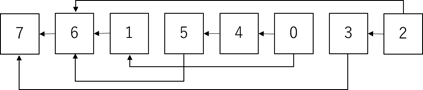

# 節末課題

1. アルゴリズムの完全性  
閉路のない有向グラフが与えられている限り，本節で示したトポロジカルソーティングを行うアルゴリズムは必ず全頂点を並べて終われることを自分なりに説明せよ．  
これは本来は証明問題である．そういう文献等を探してきて読解しそれを説明するだけでも良い．


2. 計算量  
topologicalsorting_J プログラムの時間計算量と空間計算量を議論せよ．


3. 閉路の存在  
トポロジカルソーティングに与えるグラフには閉路が存在してはならない． その理由を説明せよ．


4. 閉路の扱い  
本節の topologicalsorting_J プログラムでは，実際には閉路が含まれるグラフを与えても実行すると結果が出てしまう．これは，閉路があるとトポロジカルソーティングができないはず，ということと矛盾する．
本プログラムで実行結果がでるのは，グラフの解釈を都合のよいように勝手に変えているからと考えることができる．それでは，本プログラムでは，閉路が存在するとき，それをどう解釈しているのか，説明を試みよ．



# 出典

筑波大学工学システム学類  
データ構造とアルゴリズム  
担当：亀田能成  
2021/05/12 初版




